In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")

# https://chat.openai.com/share/18e3f2f1-a042-40ec-8148-a10e4d080050

## load dataset

In [3]:
# Load your dataset
df = pd.read_csv('./titanic/extracted_data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## preprocess tool

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess(df):
    # Handling missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Feature engineering
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1  # Initialize to yes/1 is alone
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0  # now update to no/0 if family size is greater than 1

    # Categorical variables and encoding
    label = LabelEncoder()
    df['Sex'] = label.fit_transform(df['Sex'])
    df['Embarked'] = label.fit_transform(df['Embarked'])

    # Drop features that are unlikely to be useful
    df = df.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1)

    # Feature scaling
    scaler = StandardScaler()
    df[['Age', 'Fare', 'FamilySize', "SibSp", "Parch"]] = scaler.fit_transform(df[['Age', 'Fare', 'FamilySize', "SibSp", "Parch"]])

    return df

# Assuming you have the Titanic dataset loaded as a DataFrame
# df = pd.read_csv('path_to_your_titanic_dataset.csv')
# df_processed = preprocess(df)


## define train, test dataset

In [14]:
# Load your dataset
# df = pd.read_csv('./titanic/extracted_data/train.csv')

# Preprocess the dataset (fill missing values, encode categorical variables, etc.)
df_processed = preprocess(df) # Implement this based on your dataset

# Assume df_processed has features in X and target in y
X = df_processed.drop('Survived', axis=1)
y = df_processed['Survived']



C:\Users\xdxd2\AppData\Local\Temp\ipykernel_30048\3470013827.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0  # now update to no/0 if family size is greater than 1
C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\xdxd2\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\xdxd2\AppData\Roaming\Python\Python310

## create base model and initialize predict array

In [21]:
# Define base models
model1 = RandomForestClassifier(random_state=1)
model2 = GradientBoostingClassifier(random_state=1)
model3 = LogisticRegression(random_state=1)

# Create empty numpy arrays to hold oof predictions
oof_preds1 = np.zeros(X.shape[0])
oof_preds2 = np.zeros(X.shape[0])
oof_preds3 = np.zeros(X.shape[0])


## k fold data split

In [29]:
# Stratified K-Folds cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Generating out-of-fold predictions for each model
for train_index, test_index in kf.split(X, y):

    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and make predictions with each model
    for model, oof_preds in zip([model1, model2, model3], [oof_preds1, oof_preds2, oof_preds3]):
        model.fit(X_train, y_train)
        oof_preds[test_index] = model.predict_proba(X_test)[:, 1]



In [33]:
oof_preds1.shape
oof_preds2.shape

# Create new feature set based on out-of-fold predictions
stacked_features = np.column_stack((oof_preds1, oof_preds2, oof_preds3))

stacked_features.shape



(891, 3)

## model fit

In [38]:
# Create new feature set based on out-of-fold predictions
stacked_features = np.column_stack((oof_preds1, oof_preds2, oof_preds3))

# Meta-model
meta_model = LogisticRegression(random_state=1)
meta_model.fit(stacked_features, y)


LogisticRegression(random_state=1)

## validation 

Confusion Matrix:
 [[101   8]
 [ 21  48]]
Accuracy:  0.8370786516853933
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87       109
           1       0.86      0.70      0.77        69

    accuracy                           0.84       178
   macro avg       0.84      0.81      0.82       178
weighted avg       0.84      0.84      0.83       178



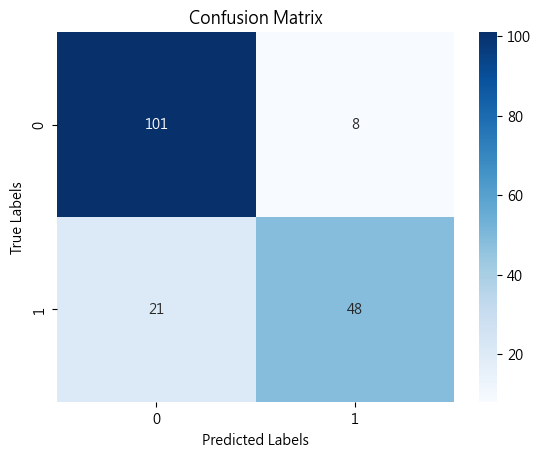

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a test dataset ready
# X_test, y_test = your_test_data_here

# Generate final predictions on test data using base models
# Replace model1, model2, model3 with your actual base models
test_preds1 = model1.predict_proba(X_test)[:, 1]
test_preds2 = model2.predict_proba(X_test)[:, 1]
test_preds3 = model3.predict_proba(X_test)[:, 1]

# Stack the predictions to create new feature set for meta-model
stacked_test_features = np.column_stack((test_preds1, test_preds2, test_preds3))

# Generate predictions using the meta-model
meta_model_predictions = meta_model.predict(stacked_test_features)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, meta_model_predictions)

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# Print accuracy
print("Accuracy: ", accuracy_score(y_test, meta_model_predictions))

# Print classification report for precision, recall, f1-score
print("Classification Report:\n", classification_report(y_test, meta_model_predictions))

# Plotting Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
